In [40]:
class SubmissionBase:

    submit_url = 'https://www-origin.coursera.org/api/' \
                 'onDemandProgrammingImmediateFormSubmissions.v1'
    save_file = 'token.pkl'

    def __init__(self, assignment_slug, part_names):
        self.assignment_slug = assignment_slug
        self.part_names = part_names
        self.login = None
        self.token = None
        self.functions = OrderedDict()
        self.args = dict()

    def grade(self):
        print('\nSubmitting Solutions | Programming Exercise %s\n' % self.assignment_slug)
        self.login_prompt()

        # Evaluate the different parts of exercise
        parts = OrderedDict()
        for part_id, result in self:
            parts[str(part_id)] = {'output': sprintf('%0.5f ', result)}
        result, response = self.request(parts)
        response = json.loads(response.decode("utf-8"))

        # if an error was returned, print it and stop
        if 'errorMessage' in response:
            print(response['errorMessage'])
            return

        # Print the grading table
        print('%43s | %9s | %-s' % ('Part Name', 'Score', 'Feedback'))
        print('%43s | %9s | %-s' % ('---------', '-----', '--------'))
        for part in parts:
            part_feedback = response['partFeedbacks'][part]
            part_evaluation = response['partEvaluations'][part]
            score = '%d / %3d' % (part_evaluation['score'], part_evaluation['maxScore'])
            print('%43s | %9s | %-s' % (self.part_names[int(part) - 1], score, part_feedback))
        evaluation = response['evaluation']
        total_score = '%d / %d' % (evaluation['score'], evaluation['maxScore'])
        print('                                  --------------------------------')
        print('%43s | %9s | %-s\n' % (' ', total_score, ' '))

    def login_prompt(self):
        if os.path.isfile(self.save_file):
            with open(self.save_file, 'rb') as f:
                login, token = pickle.load(f)
            reenter = input('Use token from last successful submission (%s)? (Y/n): ' % login)

            if reenter == '' or reenter[0] == 'Y' or reenter[0] == 'y':
                self.login, self.token = login, token
                return
            else:
                os.remove(self.save_file)

        self.login = input('Login (email address): ')
        self.token = input('Token: ')

        # Save the entered credentials
        if not os.path.isfile(self.save_file):
            with open(self.save_file, 'wb') as f:
                pickle.dump((self.login, self.token), f)

    def request(self, parts):
        params = {
            'assignmentSlug': self.assignment_slug,
            'secret': self.token,
            'parts': parts,
            'submitterEmail': self.login}

        params = urlencode({'jsonBody': json.dumps(params)}).encode("utf-8")
        f = urlopen(self.submit_url, params)
        try:
            return 0, f.read()
        finally:
            f.close()

    def __iter__(self):
        for part_id in self.functions:
            yield part_id

    def __setitem__(self, key, value):
        self.functions[key] = value


def sprintf(fmt, arg):
    """ Emulates (part of) Octave sprintf function. """
    if isinstance(arg, tuple):
        # for multiple return values, only use the first one
        arg = arg[0]

    if isinstance(arg, (np.ndarray, list)):
        # concatenates all elements, column by column
        return ' '.join(fmt % e for e in np.asarray(arg).ravel('F'))
    else:
        return fmt % arg

import sys
import numpy as np
from matplotlib import pyplot

sys.path.append('..')


def mapFeature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.
    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.
    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.
    degree: int, optional
        The polynomial degree.
    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)


def plotDecisionBoundary(plotData, theta, X, y):
    """
    Plots the data points X and y into a new figure with the decision boundary defined by theta.
    Plots the data points with * for the positive examples and o for  the negative examples.
    Parameters
    ----------
    plotData : func
        A function reference for plotting the X, y data.
    theta : array_like
        Parameters for logistic regression. A vector of shape (n+1, ).
    X : array_like
        The input dataset. X is assumed to be  a either:
            1) Mx3 matrix, where the first column is an all ones column for the intercept.
            2) MxN, N>3 matrix, where the first column is all ones.
    y : array_like
        Vector of data labels of shape (m, ).
    """
    # make sure theta is a numpy array
    theta = np.array(theta)

    # Plot Data (remember first column in X is the intercept)
    plotData(X[:, 1:3], y)

    if X.shape[1] <= 3:
        # Only need 2 points to define a line, so choose two endpoints
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calculate the decision boundary line
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        # Plot, and adjust axes for better viewing
        pyplot.plot(plot_x, plot_y)

        # Legend, specific for the exercise
        pyplot.legend(['Admitted', 'Not admitted', 'Decision Boundary'])
        pyplot.xlim([30, 100])
        pyplot.ylim([30, 100])
    else:
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        # Evaluate z = theta*x over the grid
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  # important to transpose z before calling contour
        # print(z)

        # Plot z = 0
        pyplot.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        pyplot.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)


class Grader(SubmissionBase):
    X = np.stack([np.ones(20),
                  np.exp(1) * np.sin(np.arange(1, 21)),
                  np.exp(0.5) * np.cos(np.arange(1, 21))], axis=1)

    y = (np.sin(X[:, 0] + X[:, 1]) > 0).astype(float)

    def __init__(self):
        part_names = ['Sigmoid Function',
                      'Logistic Regression Cost',
                      'Logistic Regression Gradient',
                      'Predict',
                      'Regularized Logistic Regression Cost',
                      'Regularized Logistic Regression Gradient']
        super().__init__('logistic-regression', part_names)

    def __iter__(self):
        for part_id in range(1, 7):
            try:
                func = self.functions[part_id]

                # Each part has different expected arguments/different function
                if part_id == 1:
                    res = func(self.X)
                elif part_id == 2:
                    res = func(np.array([0.25, 0.5, -0.5]), self.X, self.y)
                elif part_id == 3:
                    J, grad = func(np.array([0.25, 0.5, -0.5]), self.X, self.y)
                    res = grad
                elif part_id == 4:
                    res = func(np.array([0.25, 0.5, -0.5]), self.X)
                elif part_id == 5:
                    res = func(np.array([0.25, 0.5, -0.5]), self.X, self.y, 0.1)
                elif part_id == 6:
                    res = func(np.array([0.25, 0.5, -0.5]), self.X, self.y, 0.1)[1]
                else:
                    raise KeyError
                yield part_id, res
            except KeyError:
                yield part_id, 0



from urllib.parse import urlencode
from urllib.request import urlopen
import pickle
import json
from collections import OrderedDict
import numpy as np
import os



In [10]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

data = np.loadtxt(os.path.join('Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]
#X - Loads all rows and loads all columns from 0:2 (excludes 2)
#Y - loads all rows and all columns index 2
def plotData(X, y):
    """
    Plots the data points X and y into a new figure. Plots the data 
    points with * for the positive examples and o for the negative examples.
    
    Parameters
    ----------
    X : array_like
        An Mx2 matrix representing the dataset. 
    
    y : array_like
        Label values for the dataset. A vector of size (M, ).
    
    Instructions
    ------------
    Plot the positive and negative examples on a 2D plot, using the
    option 'k*' for the positive examples and 'ko' for the negative examples.    
    """
    # Create New Figure
    fig = pyplot.figure()

    # ====================== YOUR CODE HERE ======================
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

# Plot Examples
#X[pos,0] looks at the alignment of y == 1 (true)
#and returns all the true values in the 0th column

#Basically: If y == 1 in the corresponding row via X for the 0th column,
#Print out that value. If not, do not print it out.
# [0,1,0] y 
## X [9 10
##   11 12
##   13 14] 
## since y == 1 is true for index 1, 
##Then row 1 of column 0 will be printed
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)

    # ============================================================

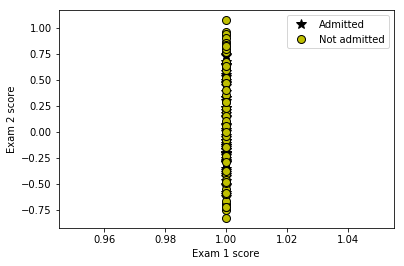

In [139]:

plotData(X, y)
# add axes labels
pyplot.xlabel('Exam 1 score')
pyplot.ylabel('Exam 2 score')
pyplot.legend(['Admitted', 'Not admitted'])
pass
    
 

    

In [102]:
# Test the implementation of sigmoid function here
z = 4
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 4 ) =  0.0179862099621


In [13]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [14]:
def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    h = sigmoid(np.dot(X,theta))
    J = (1/y.size) * np.sum(-y.dot(np.log(h))-(1-y).dot(np.log(1-h)))
    grad = (1/y.size) * (h-y).dot(X)
    #X is a m x j matrix.
    # h-y is a m x 1 matrix
    # The equation for gradient is sum of (h-y(i))x(i)(j) where j is the jth feature
    # The gradient computes each FEATURE seperately.
    # =============================================================
    return J, grad

In [15]:
initial_theta = np.zeros(n+1)

cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


In [16]:
a = np.array([[1,2,3],[1,2,3]])
b = np.array([2,2,2])
print(a.dot(b))

[12 12]


In [17]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Expected theta (approx):\n\t[-25.161, 0.206, 0.201]')

Cost at theta found by optimize.minimize: 0.203
Expected cost (approx): 0.203

theta:
	[-25.161, 0.206, 0.201]
Expected theta (approx):
	[-25.161, 0.206, 0.201]


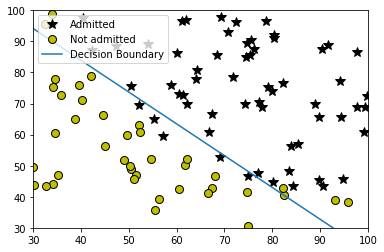

In [20]:
plotDecisionBoundary(plotData,theta, X, y)

In [136]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    p = sigmoid(np.dot(X,theta))
    
    for i in range(m):
        if (p[i] >= .5):
            p[i] = 1
        else:
            p[i] = 0

    # ============================================================
    return p

In [65]:
#  Predict probability for a student with score 45 on exam 1 
#  and score 85 on exam 2 
prob = sigmoid(np.dot([1, 45, 85], theta))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))

print('Expected value: 0.775 +/- 0.002\n')
p = predict(theta, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))
print('Expected accuracy (approx): 89.00 %')


For a student with scores 45 and 85,we predict an admission probability of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.00 %
Expected accuracy (approx): 89.00 %


In [88]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('Data', 'ex2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

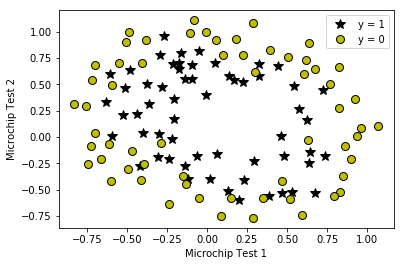

In [89]:
plotData(X, y)
# Labels and Legend
pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')

# Specified in plot order
pyplot.legend(['y = 1', 'y = 0'], loc='upper right')
pass

In [90]:
X = mapFeature(X[:,0],X[:,1])


In [107]:
def sigmoid(z):
    # convert input to a numpy array
        z = np.array(z)
    
    # You need to return the following variables correctly 
        g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
        e = 2.71828
        g = 1/(1+np.exp(-z))

    # =============================================================
        return g

In [131]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(np.dot(X,theta)) #produces a m by 1 matrix
    
    
    thetaGradient = (lambda_/m)*(theta)
    # ===================== YOUR CODE HERE ======================
    theta[0] = 0
    J = (1/m)*np.sum(-y.dot(np.log(h))-(1-y).dot(np.log(1-h))) + ((lambda_/(2*m))*(np.sum(theta*theta)))
    
    grad = ((1/m)*(h-y).dot(X))+((lambda_/(m))*(theta))
    # =============================================================
    return J, grad

In [132]:

# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


In [133]:

# appends the implemented function in part 1 to the grader object
grader[1] = sigmoid

# send the added functions to coursera grader for getting a grade on this part
grader.grade()


Submitting Solutions | Programming Exercise logistic-regression

Use token from last successful submission (canngo215@gmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Sigmoid Function |   5 /   5 | Nice work!
                   Logistic Regression Cost |   0 /  30 | 
               Logistic Regression Gradient |   0 /  30 | 
                                    Predict |   0 /   5 | 
       Regularized Logistic Regression Cost |  15 /  15 | Nice work!
   Regularized Logistic Regression Gradient |  15 /  15 | Nice work!
                                  --------------------------------
                                            |  35 / 100 |  



In [134]:
grader[2] = costFunction
grader[3] = costFunction
grader.grade()


Submitting Solutions | Programming Exercise logistic-regression

Use token from last successful submission (canngo215@gmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Sigmoid Function |   5 /   5 | Nice work!
                   Logistic Regression Cost |  30 /  30 | Nice work!
               Logistic Regression Gradient |  30 /  30 | Nice work!
                                    Predict |   0 /   5 | 
       Regularized Logistic Regression Cost |  15 /  15 | Nice work!
   Regularized Logistic Regression Gradient |  15 /  15 | Nice work!
                                  --------------------------------
                                            |  95 / 100 |  



In [137]:
grader[4] = predict
grader.grade()


Submitting Solutions | Programming Exercise logistic-regression

Use token from last successful submission (canngo215@gmail.com)? (Y/n): Y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                           Sigmoid Function |   5 /   5 | Nice work!
                   Logistic Regression Cost |  30 /  30 | Nice work!
               Logistic Regression Gradient |  30 /  30 | Nice work!
                                    Predict |   5 /   5 | Nice work!
       Regularized Logistic Regression Cost |  15 /  15 | Nice work!
   Regularized Logistic Regression Gradient |  15 /  15 | Nice work!
                                  --------------------------------
                                            | 100 / 100 |  

